# EVOLV MACHINE LEARNING CHALLENGE

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn import preprocessing
import os

Number Of Players    :  15
Number Of Images     :  576


Distribution Per Player


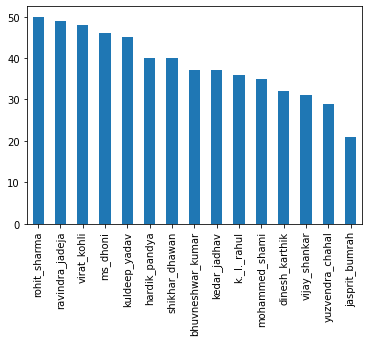

In [2]:
dataset = pd.read_csv('players.csv')
ds=dataset
ds = ds.sample(frac=1).reset_index(drop=True)

le = preprocessing.LabelEncoder()
le.fit(ds['player'])
ds['player_trans'] = le.transform(ds['player'])

n = int(len(ds))
players = ds.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Images     : ",n)
print("\n\nDistribution Per Player")
ds['player'].value_counts().plot.bar()

ds = ds[:-6]
test = ds[-6:]

In [3]:
x=dataset['image']
y=dataset['player']

In [4]:
dataset = pd.read_csv('players.csv')

In [5]:
dataset.head()

,Unnamed: 0,image,player
0,0,eda97f557b.jpg,virat_kohli
1,1,273ed0f2b9.jpg,hardik_pandya
2,2,77076b6409.jpg,jasprit_bumrah
3,3,f028e2dcf8.jpg,mohammed_shami
4,4,3364f861e1.jpg,kedar_jadhav


In [6]:
dataset.tail()

,Unnamed: 0,image,player
571,571,9df5df9ab0.jpg,bhuvneshwar_kumar
572,572,950a804c19.jpg,rohit_sharma
573,573,fe83d58508.jpg,ravindra_jadeja
574,574,6added3d92.jpg,bhuvneshwar_kumar
575,575,014c84697e.jpg,dinesh_karthik


In [7]:
dataset.describe()

,Unnamed: 0
count,576.000000
mean,287.500000
std,166.421153
min,0.000000
25%,143.750000
50%,287.500000
75%,431.250000
max,575.000000


In [8]:
dataset.shape

(576, 3)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  576 non-null    int64 
 1   image       576 non-null    object
 2   player      576 non-null    object
dtypes: int64(1), object(2)
memory usage: 13.6+ KB


In [10]:
dataset.isnull().sum()

Unnamed: 0    0
image         0
player        0
dtype: int64

# EDA

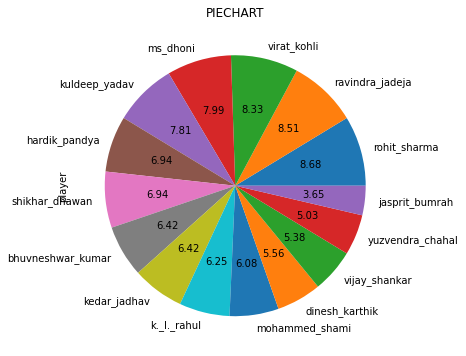

In [11]:
dataset['player'].value_counts().plot.pie(figsize=(6, 6), autopct='%.2f')
plt.title("PIECHART");

Number Of Players    :  15
Number Of Images     :  576


Distribution Per Player


<AxesSubplot:>

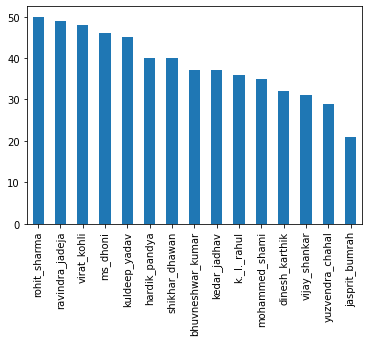

In [12]:
n = int(len(dataset))
players = dataset.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Images     : ",n)
print("\n\nDistribution Per Player")
dataset['player'].value_counts().plot.bar()

Distribution Per Player


<AxesSubplot:>

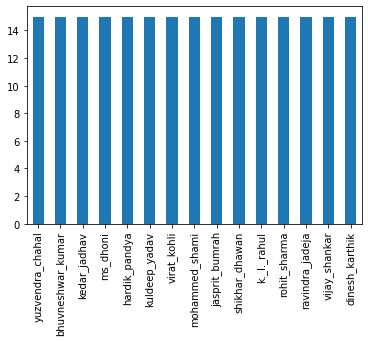

In [13]:
for index,row in dataset.iterrows():
    if len(dataset[dataset['player']==row['player']])>15:
        dataset.drop(dataset[dataset['image']==row['image']].index , inplace=True)

print("Distribution Per Player")
dataset['player'].value_counts().plot.bar()

In [14]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:image = tf.image.transpose(image)
    if p_rotate > .75:image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:image = tf.image.rot90(image, k=1) 

    if p_pixel_1 >= .4:image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:image = tf.image.random_brightness(image, max_delta=.1)

    if p_crop > .7:
        if p_crop > .9:image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:image = tf.image.central_crop(image, central_fraction=.8)
        else:image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(224*.8),224, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, [224,224])
    return image,label

def load_img(image,player,player_transf):
    path ="../Downloads/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img,player_transf
dataset = tf.data.Dataset.from_tensor_slices((ds.image.values,ds.player.values,ds.player_trans.values))

In [15]:
train_ds = dataset.take(int(0.8*n))
val_ds = dataset.skip(int(0.8*n))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_img,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat(40).map(data_augment,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

# DEFINE MODEL

In [16]:
base_model = keras.applications.MobileNetV2(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(players, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

In [17]:
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

# TRAINING

In [18]:
train_x = x[:80]
train_y = y[:80]

test_x = x[80:]
test_y = y[80:]

In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(train_ds, epochs=2, validation_data=val_ds,verbose=1,callbacks=[cp_callback])

Epoch 1/2
575/575 [==============================] - 368s 636ms/step - loss: 1.8831 - accuracy: 0.4208 - val_loss: 2.3091 - val_accuracy: 0.3091

Epoch 00001: saving model to ./checkpoints\cp.ckpt
Epoch 2/2
575/575 [==============================] - 388s 674ms/step - loss: 0.7322 - accuracy: 0.8120 - val_loss: 2.4373 - val_accuracy: 0.3545

Epoch 00002: saving model to ./checkpoints\cp.ckpt


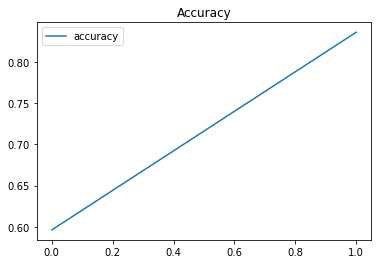

In [42]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()

# TEST CASES

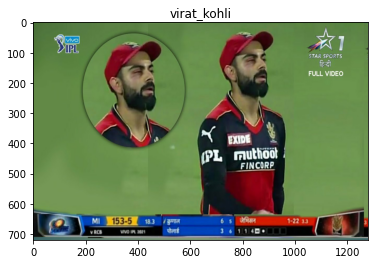

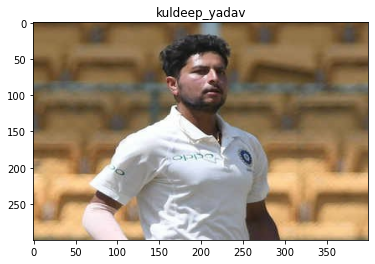

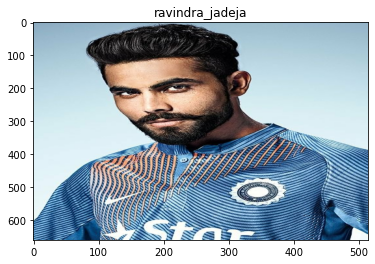

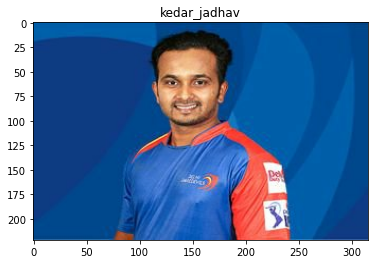

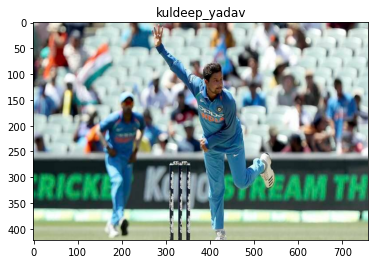

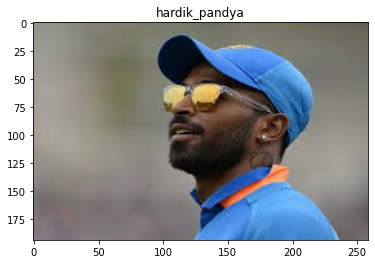

In [41]:
i=0
def load_test_img(image,player,player_transf):
    path = "../Downloads/images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img

test_ds = tf.data.Dataset.from_tensor_slices((test.image.values,test.player.values,test.player_trans.values))
test_ds = test_ds.map(load_test_img).batch(6)
prediction = model.predict(test_ds)

for index,row in test.iterrows():
    img = tf.io.decode_jpeg(tf.io.read_file("../Downloads/images/"+row['player']+"/"+row['image']),channels=3)
    imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
    real = str(list(le.classes_)[row['player_trans']])
    plt.title(str(real))
    plt.show()
    i+=1

# THANK YOU